2024-10-03 15:47:02.376033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 15:47:02.397869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 15:47:02.404565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 15:47:02.421156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 15:47:03.656741: W tensorflow/compiler/tf2

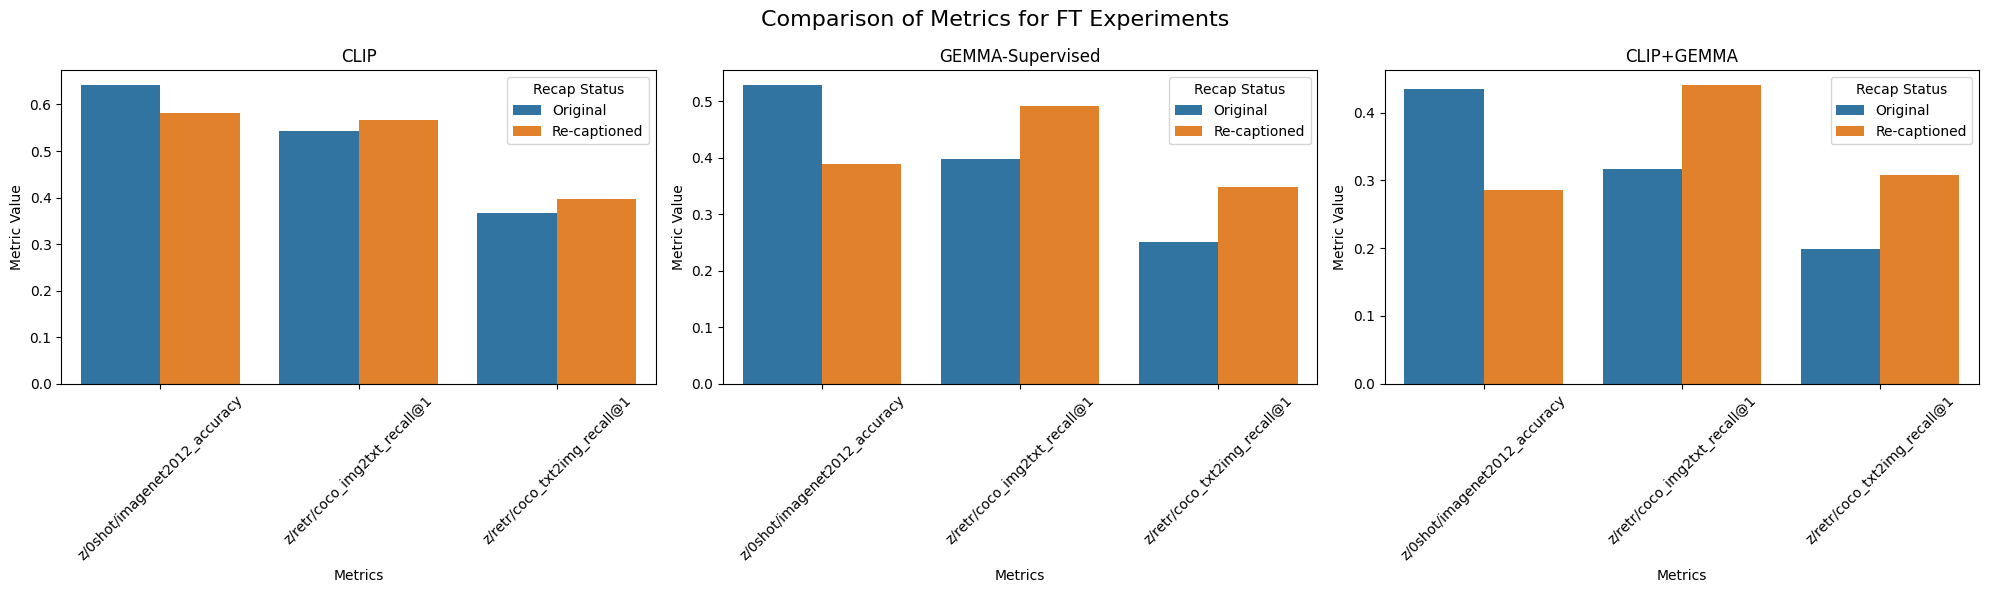


CLIP+GEMMA:
  z/0shot/imagenet2012_accuracy (Original): 0.4346
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.2863
  z/retr/coco_img2txt_recall@1 (Original): 0.3166
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.4406
  z/retr/coco_txt2img_recall@1 (Original): 0.1987
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.3077

CLIP:
  z/0shot/imagenet2012_accuracy (Original): 0.6413
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.5806
  z/retr/coco_img2txt_recall@1 (Original): 0.5420
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.5668
  z/retr/coco_txt2img_recall@1 (Original): 0.3657
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.3959

GEMMA-Supervised:
  z/0shot/imagenet2012_accuracy (Original): 0.5282
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.3882
  z/retr/coco_img2txt_recall@1 (Original): 0.3972
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.4910
  z/retr/coco_txt2img_recall@1 (Original): 0.2501
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.3481


In [1]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

datacomp_recap = {
    "FT_clip+gemma_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-03_0440",
    "FT_clip+gemma_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_10-03_0440",
    "FT_clip_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-02_1912",
    "FT_clip_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapT_10-01_1442",
    "FT_gemma-supervised_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/gemma-supervised_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-02_1727",
    "FT_gemma-supervised_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/gemma-supervised_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_10-02_1437",
}

def get_final_metrics(experiment_name):
    ckpt_path = datacomp_recap[experiment_name]
    metrics_path = f'{ckpt_path}/big_vision_metrics.txt'

    final_metrics = {}
    with tf.io.gfile.GFile(metrics_path, 'r') as f:
        lines = f.read().split('\n')
        last_line = json.loads(lines[-2])  # Use -2 to avoid empty last line
        metrics_of_interest = [
            "z/0shot/imagenet2012_accuracy",
            "z/retr/coco_img2txt_recall@1",
            "z/retr/coco_txt2img_recall@1",
        ]
        for key in metrics_of_interest:
            if key in last_line:
                final_metrics[key] = last_line[key]
    return final_metrics

# Collect final metrics for all experiments
all_metrics = {exp: get_final_metrics(exp) for exp in datacomp_recap.keys()}

# Prepare data for plotting
plot_data = []
for exp, metrics in all_metrics.items():
    model_type = 'CLIP' if 'clip_recap' in exp else ('CLIP+GEMMA' if 'clip+gemma' in exp else 'GEMMA-Supervised')
    recap = 'Re-captioned' if 'recapT' in exp else 'Original'
    for metric, value in metrics.items():
        plot_data.append({
            'Model': model_type,
            'Recap': recap,
            'Metric': metric,
            'Value': value
        })

# Convert to DataFrame
df = pd.DataFrame(plot_data)

# Set up the plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Comparison of Metrics for FT Experiments', fontsize=16)

# Create a plot for each model type
for i, model in enumerate(['CLIP', 'GEMMA-Supervised', 'CLIP+GEMMA']):
    model_data = df[df['Model'] == model]
    
    sns.barplot(x='Metric', y='Value', hue='Recap', data=model_data, ax=axes[i])
    
    axes[i].set_title(model)
    axes[i].set_xlabel('Metrics')
    axes[i].set_ylabel('Metric Value')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Recap Status')

plt.tight_layout()
plt.show()

# Print the results
for model in df['Model'].unique():
    print(f"\n{model}:")
    for metric in df['Metric'].unique():
        for recap in df['Recap'].unique():
            value = df[(df['Model'] == model) & (df['Metric'] == metric) & (df['Recap'] == recap)]['Value'].values[0]
            print(f"  {metric} ({recap}): {value:.4f}")

In [2]:
df

,Model,Recap,Metric,Value
0,CLIP+GEMMA,Original,z/0shot/imagenet2012_accuracy,0.434580
1,CLIP+GEMMA,Original,z/retr/coco_img2txt_recall@1,0.316600
2,CLIP+GEMMA,Original,z/retr/coco_txt2img_recall@1,0.198681
3,CLIP+GEMMA,Re-captioned,z/0shot/imagenet2012_accuracy,0.286260
4,CLIP+GEMMA,Re-captioned,z/retr/coco_img2txt_recall@1,0.440600
5,CLIP+GEMMA,Re-captioned,z/retr/coco_txt2img_recall@1,0.307717
6,CLIP,Original,z/0shot/imagenet2012_accuracy,0.641340
7,CLIP,Original,z/retr/coco_img2txt_recall@1,0.542000
8,CLIP,Original,z/retr/coco_txt2img_recall@1,0.365734
9,CLIP,Re-captioned,z/0shot/imagenet2012_accuracy,0.580640
